In [1]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.34.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler

import os
import tensorflow as tf
import tensorflowjs as tfjs
from google.colab import files

In [3]:
# Fungsi untuk menghitung metrik evaluasi
def calculate_metrics(y_true, y_pred):
    metrics = {
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred)
    }
    return metrics

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = pd.read_csv('/content/drive/MyDrive/prediksi_cuaca/df_filtered_local.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3617 entries, 0 to 3616
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           3617 non-null   object 
 1   Tn             3617 non-null   float64
 2   Tx             3617 non-null   float64
 3   Tavg           3617 non-null   float64
 4   RH_avg         3617 non-null   float64
 5   RR             3617 non-null   float64
 6   ss             3617 non-null   float64
 7   ff_x           3617 non-null   float64
 8   ddd_x          3617 non-null   float64
 9   ff_avg         3617 non-null   float64
 10  ddd_car        3617 non-null   object 
 11  station_id     3617 non-null   int64  
 12  station_name   3617 non-null   object 
 13  region_name    3617 non-null   object 
 14  latitude       3617 non-null   float64
 15  longitude      3617 non-null   float64
 16  region_id      3617 non-null   int64  
 17  province_id    3617 non-null   int64  
 18  province

In [ ]:
# # Eksplorasi Data (EDA)
# url = '/content/df_filtered_local.csv'
# data = pd.read_csv(url)
# data.rename(columns={data.columns[1]: 'CO2'}, inplace=True)
# print(data.info())

In [6]:
data['date'] = pd.to_datetime(data['date'])
y = data["Tavg"]

In [7]:
# Analisis Statistik deskriptif Awal
print("\nStatistik deskriptif Awal:")
print(data.describe())


Statistik deskriptif Awal:
                                date           Tn           Tx         Tavg  \
count                           3617  3617.000000  3617.000000  3617.000000   
mean   2015-08-22 16:46:02.952723200    23.594802    33.389052    27.599309   
min              2010-01-01 00:00:00    17.000000    24.800000    23.800000   
25%              2012-06-23 00:00:00    23.000000    32.200000    26.900000   
50%              2015-11-28 00:00:00    24.000000    33.600000    27.600000   
75%              2018-05-30 00:00:00    24.000000    34.600000    28.300000   
max              2020-12-31 00:00:00    26.600000    38.600000    31.900000   
std                              NaN     1.088793     1.811218     1.032954   

            RH_avg           RR           ss         ff_x        ddd_x  \
count  3617.000000  3617.000000  3617.000000  3617.000000  3617.000000   
mean     78.087365     3.343655     5.297622     7.049765   318.952447   
min      55.000000     0.000000     0.

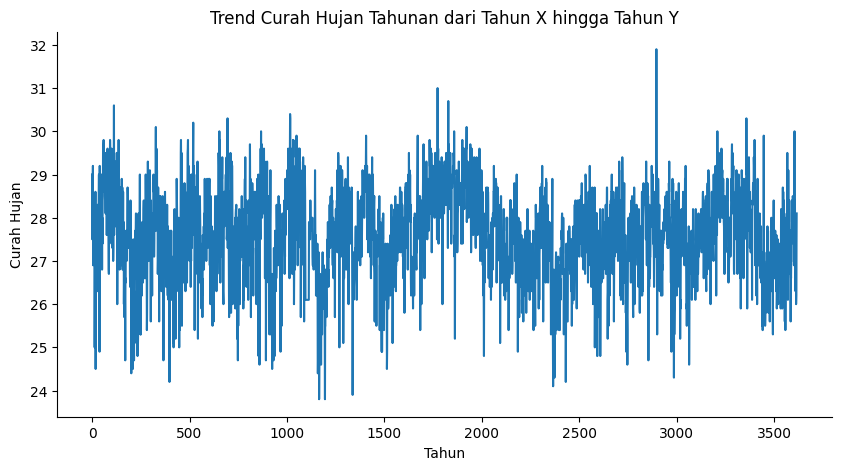

In [8]:
# Plot data RR dengan judul yang lebih deskriptif
data['Tavg'].plot(kind='line', figsize=(10, 5), title='Trend Curah Hujan Tahunan dari Tahun X hingga Tahun Y')
plt.gca().spines[['top', 'right']].set_visible(False)  # Sembunyikan spines atas dan kanan
plt.xlabel('Tahun')  # Label sumbu X
plt.ylabel('Curah Hujan')  # Label sumbu Y
plt.show()

## LSTM

In [9]:
# Model LSTM
scaler = StandardScaler()
data_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

In [10]:
# Membagi data training dan testing
train_size = int(len(data_scaled) * 0.8)
train_data, test_data = data_scaled[0:train_size, :], data_scaled[train_size:len(data_scaled), :]

In [11]:
# Fungsi untuk membuat dataset dengan time steps
def create_dataset(dataset, time_steps=1):
    X, Y = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), 0]
        X.append(a)
        Y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(Y)

In [12]:
# Membuat dataset dengan time steps
time_steps = 7
# Assuming num_features is 1 for a univariate time series
num_features = 1
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

In [13]:
# Reshape data untuk LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [25]:
# Membuat model LSTM
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(time_steps, num_features)))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping], verbose=1)

Epoch 1/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.8363 - val_loss: 0.6308
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.6851 - val_loss: 0.5687
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.6258 - val_loss: 0.5457
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.6042 - val_loss: 0.5512
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.6325 - val_loss: 0.5448
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.6208 - val_loss: 0.5445
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.6291 - val_loss: 0.5437
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.5975 - val_loss: 0.5453
Epoch 9/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.6077 - val_loss: 0.5559
Epoch 10/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.6220 - val_loss: 0.5531
Epoch 11/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.6142 - val_loss: 0.5518
Epoch 12/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step

In [27]:
# Prediksi menggunakan model LSTM
predicted_values_lstm = model.predict(X_test)
predicted_values_lstm = scaler.inverse_transform(predicted_values_lstm)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


In [28]:
# Evaluate Model LSTM
actual_values_lstm = y[-len(predicted_values_lstm):].values  # Convert to NumPy array

# Ensure both actual and predicted values have the same length
if len(actual_values_lstm) != len(predicted_values_lstm):
    print("Length mismatch between actual and predicted values.")
else:
    # Calculate metrics
    metrics_lstm = calculate_metrics(actual_values_lstm, predicted_values_lstm)
    print("\nMetrics Evaluation for LSTM Model:")
    print(metrics_lstm)


Metrics Evaluation for LSTM Model:
{'MAE': 0.5530349428184861, 'MSE': 0.5392647756359809, 'RMSE': np.float64(0.7343464956244979), 'R2': 0.37507658145850187}


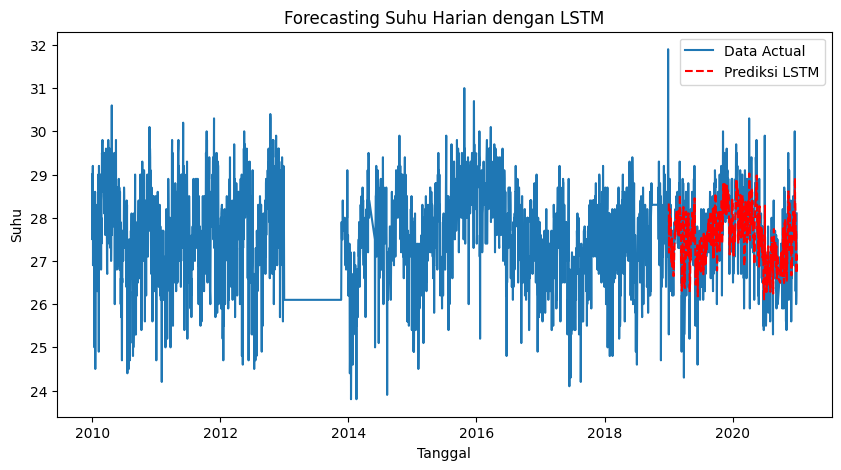

In [29]:
# Visualisasi Forecasting dengan LSTM
plt.figure(figsize=(10, 5))
# Adjust the indices for plotting
plt.plot(data['date'], data['Tavg'], label='Data Actual')
plt.plot(data['date'].tail(len(predicted_values_lstm)), predicted_values_lstm.flatten(), label='Prediksi LSTM', linestyle='dashed', color='red')
plt.title('Forecasting Suhu Harian dengan LSTM')
plt.xlabel('Tanggal')
plt.ylabel('Suhu')
plt.legend()
plt.show()


In [30]:
# Prediksi untuk beberapa hari ke depan dengan LSTM
days_to_predict = 15
last_data = np.array([test_data[-1]])
predicted_values_future = []

for i in range(days_to_predict):
    prediction = model.predict(np.reshape(last_data, (1, 1, 1)))
    last_data = np.array([prediction])
    prediction_inverse = scaler.inverse_transform(prediction)
    predicted_values_future.append(prediction_inverse[0, 0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


In [31]:
# Inverse transform the future predictions
predicted_values_future = scaler.inverse_transform(np.array(predicted_values_future).reshape(-1, 1))

# Membuat dataframe hasil prediksi
date_future = pd.date_range(start=data['date'].max() + pd.to_timedelta(1, unit='D'), periods=days_to_predict)
future_df = pd.DataFrame({'Year': date_future, 'Predicted_Price': predicted_values_future.flatten()})

# Menampilkan dataframe hasil prediksi
print("\nHasil Prediksi Suhu untuk 30 Hari ke Depan:")
print(future_df)


Hasil Prediksi Suhu untuk 30 Hari ke Depan:
         Year  Predicted_Price
0  2021-01-01        56.343491
1  2021-01-02        56.217735
2  2021-01-03        56.161228
3  2021-01-04        56.135944
4  2021-01-05        56.124657
5  2021-01-06        56.119617
6  2021-01-07        56.117374
7  2021-01-08        56.116371
8  2021-01-09        56.115925
9  2021-01-10        56.115726
10 2021-01-11        56.115635
11 2021-01-12        56.115597
12 2021-01-13        56.115578
13 2021-01-14        56.115570
14 2021-01-15        56.115570


In [32]:
def mse(y_true, y_pred):
    return tf.keras.metrics.mean_squared_error(y_true, y_pred)

# Simpan model .h5
model.save("tflite_model/model.h5")  # Simpan model .h5

# Load ulang model dari .h5 (penting agar bisa dikonversi)
loaded_model = tf.keras.models.load_model("tflite_model/model.h5", custom_objects={'mse': mse})

# Simpan model TFLite
with open("tflite_model/converted_model.tflite", "wb") as f:
    f.write(tflite_model)

In [34]:
import pickle

os.makedirs('model_output', exist_ok=True)

with open('model_output/model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('model_output/model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [41]:
# Unduh file
import zipfile

with zipfile.ZipFile("model_tflite.zip", 'w') as zipf:
    zipf.write("tflite_model/converted_model.tflite", arcname="converted_model.tflite")

files.download("tflite_model/model.h5")
files.download("model_tflite.zip")
files.download("model_output/model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>